In [2]:
using Random;
using Plots;
using LinearAlgebra;
gr()
using Statistics;

In [3]:
Random.seed!(0);

In [4]:
# 群れ中心へ進行する力
function cohesion_F(Δ)

    α = 2.0;
    
    F = α * Δ;
    
    return F;
    
end

cohesion_F (generic function with 1 method)

In [5]:
# 同一方向へ進行する力
function ahead_F(Δ)

    α = 0.5;    
    
    F = α * Δ;
    
    return F;
    
end

ahead_F (generic function with 1 method)

In [6]:
# 回避行動
function avoid_F(boids)
    
    @simd for i in 1:length(boids)
    
        # 自分とは比較しない
        neighbour = [boid for boid in boids if boid != boids[i]];
        
        # 隣のboidとの距離を算出し、分離するようにする。
        # boidごとに、現在地から、中心点への位置ベクトルを算出
        @simd for n in 1:length(neighbour)

            @inbounds to_neighbour_agent = boids[i].pos - neighbour[n].pos;
            
            # 距離
            distance = norm(to_neighbour_agent);

            avoid_distance = boids[i].radius + neighbour[n].radius - distance;

            if avoid_distance > 0

                @inbounds boids[i].pos = boids[i].pos + (to_neighbour_agent / distance) * avoid_distance;
                
            end
        end
    end
    
end

avoid_F (generic function with 1 method)

In [7]:
# ランダム行動
#function random_F(F,xmin, xmax, ymin, ymax)
function random_F(F)

    α = 1.0;
    
    F = vec([α * rand() * F[1], α * rand() * F[2]]);
    
    return F;
    
end

random_F (generic function with 1 method)

In [8]:
# 分離行動
function seperate_F(i, boids, pos)

    F = vec([0.0, 0.0]);
    
    neighbor = [boid for boid in boids if boid != boids[i]];
    
    # 隣のboidとの距離を算出し、分離するようにする。
    # boidごとに、現在地から、中心点への位置ベクトルを算出
    @simd for n in 1:length(neighbor)
        
        @inbounds to_neighbor_agent = pos - neighbor[n].pos;
        
        F = F + normalize(vec(to_neighbor_agent)) / norm(to_neighbor_agent);

    end
    
    return F;
    
end

seperate_F (generic function with 1 method)

In [9]:
# Fの合力を算出する
function calculate_F(i, boid, pos, Δ, total_ahead_Δ)

    F = vec([0.0, 0.0]);
    
    # 同一方向へ移動
    F = F + ahead_F(total_ahead_Δ);
    
    # 分離行動
    F = F + seperate_F(i, boid, pos);
    
    # 集約行動
    F = F + cohesion_F(Δ);
    
    # ランダムな行動
    F = F + random_F(F);
    
    return F;
    
end

calculate_F (generic function with 1 method)

In [10]:
# boidの振る舞いを決定
function decide_boid_action(boid, dt)

    # boid全体の中心点を算出実施
    sum = vec([0.0, 0.0]);

    @simd for i in 1:length(boid)
        @inbounds sum = sum + boid[i].pos;
    end
    
    center = sum / length(boid);
    
    total_ahead_Δx_y = vec([0,0]);
    
    # Boidインスタンスごとに、現在地から、群れ中心点への位置ベクトルを算出
    # Boid群の移動方向を算出
    @simd for i in 1:length(boid)

        @inbounds boid[i].Δx_y = center - boid[i].pos;
        @inbounds total_ahead_Δx_y = total_ahead_Δx_y + boid[i].spd;
    
    end

    total_ahead_Δx_y = total_ahead_Δx_y / length(boid);    
    
    # F = m a モデル (a = F / m)で 、速度を算出する
    # ここで、Fは位置ベクトルの大きさに比例するものとする
    @simd for i in 1:length(boid)

        # 力の演算
        F = calculate_F(i, boid, boid[i].pos, boid[i].Δx_y, total_ahead_Δx_y);
        
        # 加速度の計算実施
        acc = F / boid[i].massive;
        
        # 速度計算
        @inbounds boid[i].spd = boid[i].spd + acc * dt;
        @inbounds boid[i].pos = boid[i].pos + boid[i].spd * dt;
        
    end

    # 回避行動
    avoid_F(boid);
    
end

decide_boid_action (generic function with 1 method)

In [11]:
# boidの構造体
mutable struct boid

    # 速度
    spd;
    # 位置
    pos;
    # Boidと集団の中心との距離差分ベクトル
    Δx_y;    
    # 質量
    massive::Float64;
    # 半径
    radius::Float64;
    boid() = new();
    
end

In [12]:
# boidの初期化
function initial_boid(Boids, n)
    @simd for i in 1:n

        Boids[i] = boid();
        Boids[i].spd  = vec(100.0 * randn(1,2));
        Boids[i].Δx_y = vec([0.0, 0.0]);
        Boids[i].pos  = vec(100.0 * randn(1,2));
        Boids[i].massive = 50.0 * abs(rand());
        Boids[i].radius  = 50.0 * abs(rand());

    end
end

initial_boid (generic function with 1 method)

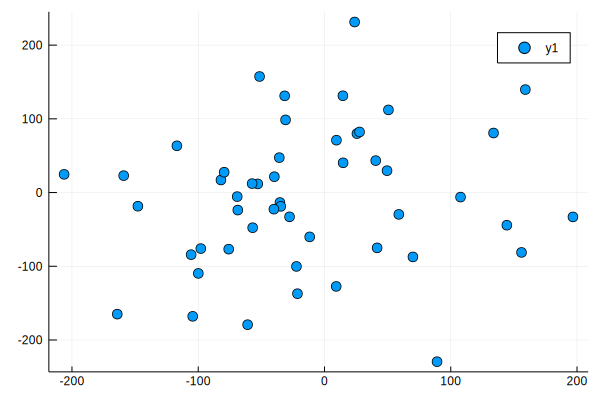

In [13]:
# Boid インスタンスの数
BOID_NUM = 50;

# Boid ライフイベント数
BOID_LIFE_TIME = 2000;

# Boidsインスタンスの宣言、生成実施
Boids = Array{boid}(undef, BOID_NUM);

# Boids インスタンスの初期化実施
initial_boid(Boids, BOID_NUM);

X = [boid.pos[1] for boid in Boids]
Y = [boid.pos[2] for boid in Boids]

plot(X, Y, st=:scatter, markersize=5)

In [14]:
i = 0;

anim = Animation();

xmin = min(Int(round(minimum(X))),  9999);
xmax = max(Int(round(maximum(X))), -9999);

ymin = min(Int(round(minimum(Y))),  9999);
ymax = max(Int(round(maximum(Y))), -9999);

life_span_unit = 1000;

while i <= BOID_LIFE_TIME
    
    if i % life_span_unit == 0
        println(i);
    end
    
    # Boidsの状態を更新
    decide_boid_action(Boids, 0.1);
    
    X = [boid.pos[1] for boid in Boids];
    Y = [boid.pos[2] for boid in Boids];
   
    global xmin = - 1000 + median(X);
    global xmax =   1000 + median(X);

    global ymin = - 1000 + median(Y);
    global ymax =   1000 + median(Y);
    
    plt = plot(X, Y, st=:scatter, xlims=(xmin,xmax), ylims=(ymin,ymax), markersize=5)
    
    frame(anim, plt);
    
    i = i + 1;
end

0
1000
2000


In [15]:
gif(anim, "bois_movement.gif", fps = 120)

┌ Info: Saved animation to 
│   fn = C:\Users\k3ijo\project\bois_movement.gif
└ @ Plots C:\Users\k3ijo\.julia\packages\Plots\oiirH\src\animation.jl:90


Plots.AnimatedGif("C:\\Users\\k3ijo\\project\\bois_movement.gif")